# Exploring batch effects in the LINCS L1000 data

---


## _Zichen Wang, Avi Ma'ayan_

<img src="http://lincs-dcic.org/images/dcic-logo/DCIC_500x375_cropped.png" style="float: right; width: 100px;"/>

#### BD2K-LINCS Data Coordination and Integration Center (DCIC)<br>Mount Sinai Center for Bioinformatics<br>Icahn School of Medicine at Mount Sinai, New York, NY<br>Grant # U54HL127624

#### CMap Workshop - Dec. 4-6, 2018 

---

## Table of Contents

1. [Explore the batch effects in the Level 3 data](#1.-Explore-batch-effects-in-the-Level-3-data)
1. [Explore the batch effects in the Level 5 data](#2.-Batch-effects-in-the-Level-5-data)
    + Approaches for visualizing and quantifying the batch effects
    + Benchmarks for batch effect correction methods for the Level 5 data, comparing different computational pipelines
    
1. [Visualizing Level 5 signatures](#3.-Interactive-visualization-of-the-signatures)
    + Interactive scatter plots
    + Graph-based dimensionality reduction methods
    
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set paths to find the data required
## paths on jupyter.clue.io
DATA_DIR = '/srv/data/workshop/data/common'
DATA_MODULE3_DIR = '/srv/data/workshop/data/Module3'

## paths on my desktop
# DATA_DIR = '/Volumes/Untitled/Zichen_Projects/LINCS_L1000_GSE92742_data/data/'
# DATA_MODULE3_DIR = '/Volumes/Untitled/Zichen_Projects/LINCS_L1000_GSE92742_data/data/'

In [3]:
from __future__ import print_function, division
import os, sys
import warnings
warnings.filterwarnings("ignore")
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold, metrics
np.random.seed(2018)

%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='whitegrid')

In [4]:
import plots
import gctx_utils

---
# 1. Explore batch effects in the Level 3 data

**Level 3 (Q2NORM)**: contains the gene expression profiles of both directly measured landmark transcripts plus inferred genes. This data is normalized using invariant set scaling followed by quantile normalization.

The data files can be downloaded from GEO at: [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)

In [5]:
!ls -lh /srv/data/workshop/data/common/

total 83G
-rwxrwxrwx 1 root root  61G Nov 29 10:23 GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx
-rw-r--r-- 1 root root  22G Nov 13 18:37 GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
-rw-r--r-- 1 root root  12K Nov 13 18:40 GSE92742_Broad_LINCS_cell_info.txt
-rw-r--r-- 1 root root 608K Nov 13 18:40 GSE92742_Broad_LINCS_gene_info.txt
-rw-r--r-- 1 root root 142M Nov 13 18:39 GSE92742_Broad_LINCS_inst_info.txt
-rw-r--r-- 1 root root 4.6M Nov 13 18:39 GSE92742_Broad_LINCS_pert_info.txt
-rw-r--r-- 1 root root 2.8M Nov 13 18:39 GSE92742_Broad_LINCS_pert_metrics.txt
-rw-r--r-- 1 root root 101M Nov 13 18:38 GSE92742_Broad_LINCS_sig_info.txt
-rw-r--r-- 1 root root  49M Nov 13 18:38 GSE92742_Broad_LINCS_sig_metrics.txt


In [6]:
# Level 3 data
gctx3 = h5py.File('%s/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx' % DATA_DIR, 'r')

## 1.1. Parsing the metadata 
- Mapping genes
- Mapping instances: corresponds to a well on the 386-well plate

In [7]:
gene_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_gene_info.txt' % DATA_DIR, 
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
gene_info_df.head()

(12328, 4)


pr_gene_symbol                                pr_gene_title  \
pr_gene_id                                                               
780                  DDR1  discoidin domain receptor tyrosine kinase 1   
7849                 PAX8                                 paired box 8   
2978               GUCA1A               guanylate cyclase activator 1A   
2049                EPHB3                              EPH receptor B3   
2101                ESRRA              estrogen related receptor alpha   

            pr_is_lm  pr_is_bing  
pr_gene_id                        
780                1           1  
7849               1           1  
2978               0           0  
2049               0           1  
2101               0           1

In [8]:
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print(len(LM_GENE_IDS))

978


In [9]:
# Metadata of instances
inst_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_inst_info.txt' % DATA_DIR, 
                          sep='\t')
inst_info_df.set_index(inst_info_df.columns[0], inplace=True)
print(inst_info_df.shape)
inst_info_df.head()

(1319138, 10)


rna_plate rna_well pert_id  \
inst_id                                                                      
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13  ASG001_MCF7_24H_X1      F13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13  ASG001_MCF7_24H_X1      G13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13  ASG001_MCF7_24H_X1      I13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13  ASG001_MCF7_24H_X1      K13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13  ASG001_MCF7_24H_X1      N13    DMSO   

                                      pert_iname    pert_type  pert_dose  \
inst_id                                                                    
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13       DMSO  ctl_vehicle        0.1   

                                      pert_dose_unit  pert_time  \
inst_id                                                           
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13              %         24   

                                      pert_time_unit cell_id  
inst_id                                                       
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13              h    MCF7

In [10]:
inst_info_df['pert_type'].value_counts()

trt_cp         672128
trt_sh         448737
trt_oe          87765
ctl_vector      30400
ctl_vehicle     28463
trt_lig         25739
ctl_untrt       22072
trt_oe.mut       3834
Name: pert_type, dtype: int64

Select compound treatment (`trt_cp`) and their controls (`ctr_vehicle`)

In [11]:
inst_info_df = inst_info_df.loc[inst_info_df['pert_type'].isin(['trt_cp', 'ctl_vehicle'])]
print(inst_info_df.shape)

(700591, 10)


In [12]:
# Find the top cell lines
inst_info_df['cell_id'].value_counts().head(10)

VCAP      125539
MCF7      103448
PC3        96014
A549       60622
A375       54971
HT29       53436
HA1E       32613
HCC515     27449
HEPG2      19019
NPC        15060
Name: cell_id, dtype: int64

In [13]:
# Only examine samples from PC3 cell line
# but you can select any other cell lines
inst_info_df = inst_info_df.query('cell_id == "PC3"')
# inst_info_df = inst_info_df.query('cell_id == "NPC"')
inst_info_df.shape

(96014, 10)

In [14]:
inst_info_df.pert_type.value_counts()

trt_cp         91954
ctl_vehicle     4060
Name: pert_type, dtype: int64

In [15]:
inst_info_df.rna_plate.value_counts().head()

PCLB001_PC3_24H_X1    1055
CPC009_PC3_6H_X3       736
CPC006_PC3_24H_X2      731
CPC019_PC3_24H_X1      728
CPC001_PC3_24H_X3      721
Name: rna_plate, dtype: int64

In [16]:
inst_info_df.query('pert_type =="ctl_vehicle"')['rna_plate'].value_counts().head()

PRISM001_PC3_24H_X1    36
DEB001_PC3_6H_X2.A2    36
RAD001_PC3_6H_X2       36
PRISM001_PC3_6H_X1     34
DEB001_PC3_24H_X2      32
Name: rna_plate, dtype: int64

In [17]:
# Extract pert_plate and det_plate from the instance_id
inst_info_df['batch'] = inst_info_df['rna_plate'].map(lambda x: '_'.join(x.split('_')[:3]))
inst_info_df['pert_plate'] = inst_info_df['rna_plate'].map(lambda x: x.split('_')[0])
inst_info_df['det_plate'] = inst_info_df.index.map(lambda x: x.split(':')[0])

In [18]:
inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC001_PC3_24H', 'CPC006_PC3_24H'])]
# inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC018_NPC_24H', 'CPC012_NPC_24H'])]
inst_ids_pclb.shape

(4389, 13)

In [20]:
# inst_ids_pclb['rna_plate'].value_counts()

CPC006_PC3_24H_X2    731
CPC001_PC3_24H_X3    721
CPC001_PC3_24H_X4    375
CPC001_PC3_24H_X2    368
CPC001_PC3_24H_X5    368
CPC006_PC3_24H_X3    367
CPC006_PC3_24H_X5    367
CPC006_PC3_24H_X1    366
CPC006_PC3_24H_X4    363
CPC001_PC3_24H_X1    363
Name: rna_plate, dtype: int64

In [21]:
# inst_ids_pclb['det_plate'].value_counts()

CPC001_PC3_24H_X4_F2B4_DUO52HI53LO    375
CPC001_PC3_24H_X2_B3_DUO52HI53LO      368
CPC001_PC3_24H_X5_B5_DUO52HI53LO      368
CPC006_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC001_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC006_PC3_24H_X5_B4_DUO52HI53LO      367
CPC006_PC3_24H_X2_B4_DUO52HI53LO      366
CPC006_PC3_24H_X1_B4_DUO52HI53LO      366
CPC006_PC3_24H_X2_F1B3_DUO52HI53LO    365
CPC001_PC3_24H_X1_B3_DUO52HI53LO      363
CPC006_PC3_24H_X4_B4_DUO52HI53LO      363
CPC001_PC3_24H_X3_B3_DUO52HI53LO      354
Name: det_plate, dtype: int64

## 1.2. Examine different batch effects in the Level 3 data with regards to:

- Perturbagen plate (`pert_plate`, example CPC005): contains aliquots of the treatment perturbagens (e.g., test compounds dissolved in DMSO)

- RNA plate (`rna_plate`, example CPC005_A549_24H_X1): contains perturbagen-treated cells. Also referred to as Lysate plate. These plates are given a name containing descriptions of what is in the plate with the format pert plate_cell line_time point_replicate.

- Detection plate (`det_plate`, example CPC005_A549_24H_X1_B20): contains amplicon (derived from perturbagen-treated cell lysates) that has been hybridized to Luminex beads such that the amplicon levels can be measured by a Luminex scanner. These plates are named the same as the RNA plate name but with the name of the bead batch used for that plate added at the end.

https://clue.io/connectopedia/category/Analytical%20Methods

In [19]:
# Retrieve the slice of the expression matrix from the gctx file
mat = gctx_utils.slice_matrix(gctx3,
                   rids=LM_GENE_IDS,
                   cids=inst_ids_pclb.index.values.astype(np.str)
                   )
mat.shape

(4389, 978)

In [20]:
inst_ids_pclb['pert_type'].value_counts()

trt_cp         4251
ctl_vehicle     138
Name: pert_type, dtype: int64

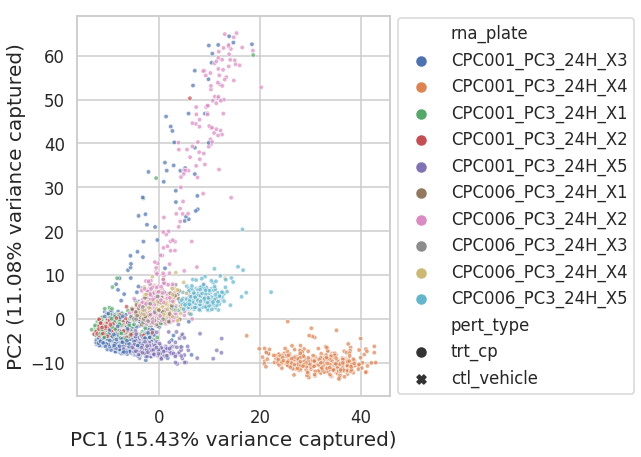

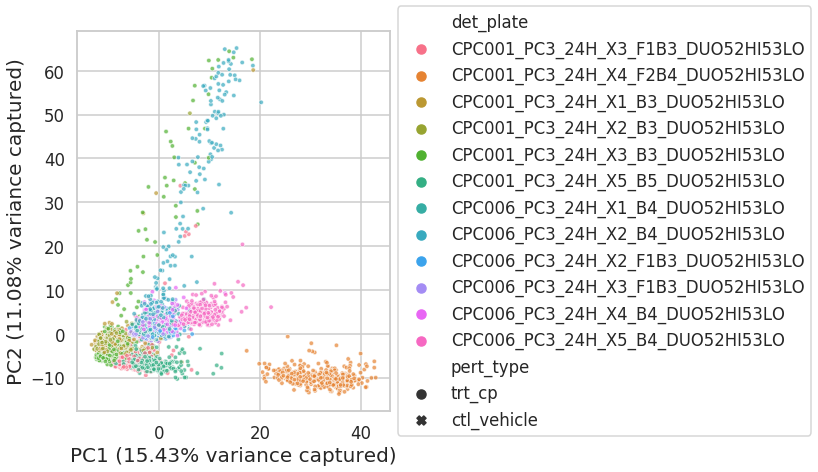

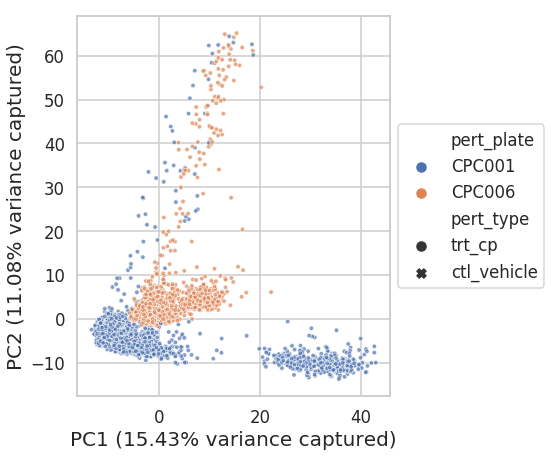

In [21]:
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='pert_plate', style='pert_type', standardize=3)

## 1.3. Mitigate the batch effects by mean centering within the batches


In [22]:
mat_centered_by_rna = gctx_utils.mean_center(mat, inst_ids_pclb['rna_plate'])

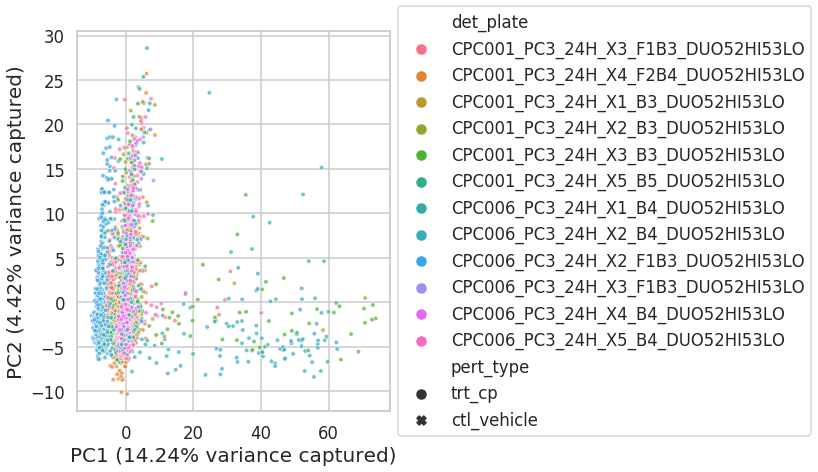

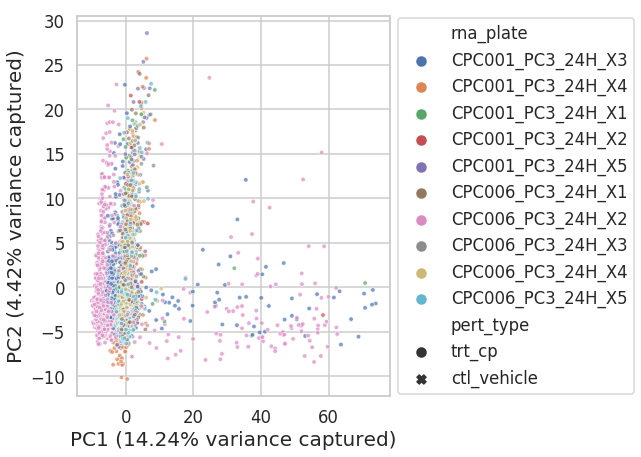

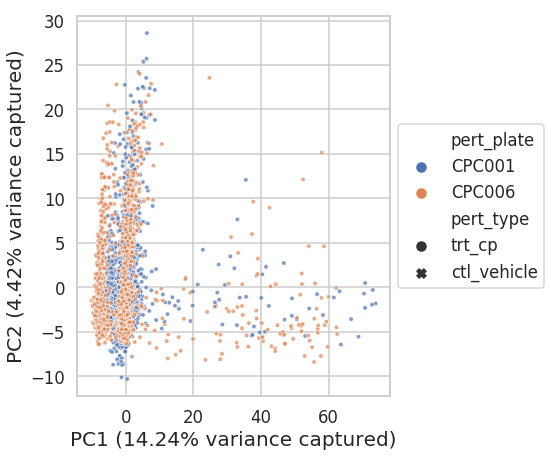

In [23]:
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='pert_plate', style='pert_type', standardize=3)

In [24]:
mat_centered_by_det = gctx_utils.mean_center(mat, inst_ids_pclb['det_plate'])

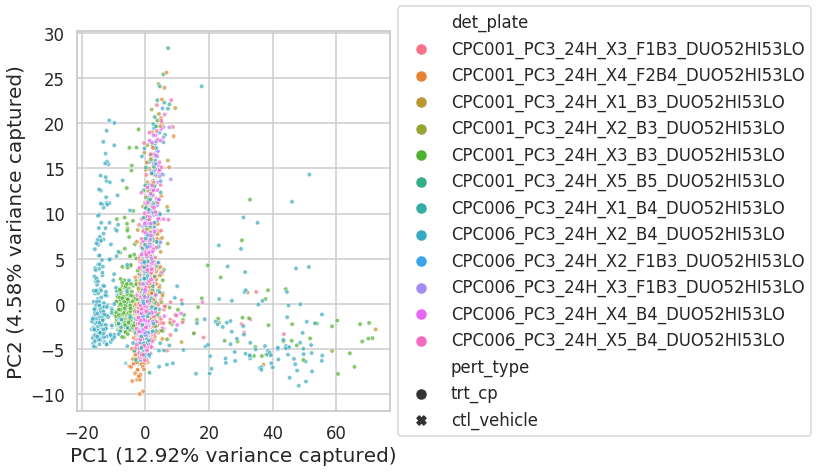

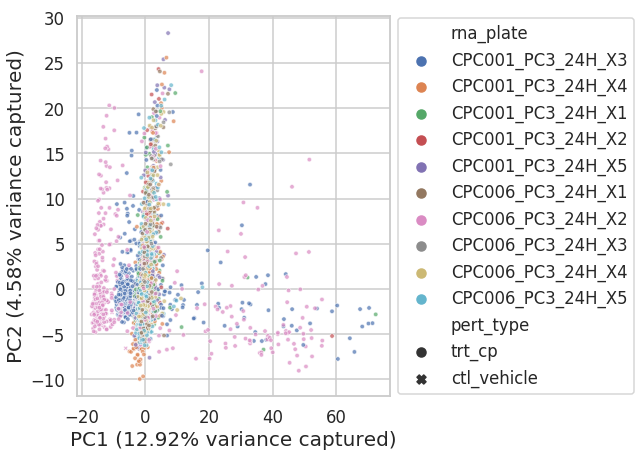

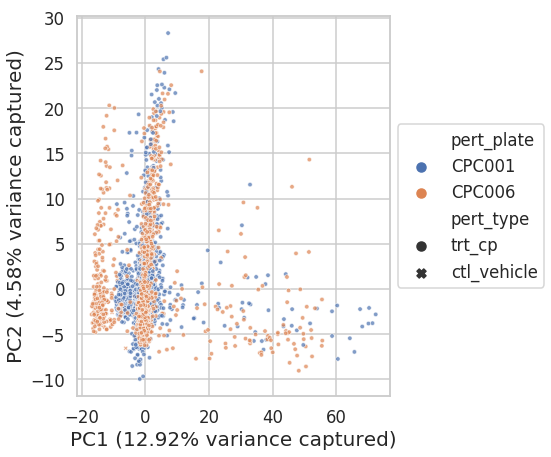

In [25]:
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='pert_plate', style='pert_type', standardize=3)

## 1.4. More sophisticated methods for batch effect correction to consider are:

- [ComBat](https://academic.oup.com/biostatistics/article/8/1/118/252073): uses empirical Bayes method to estimate the batch effect parameters affecting observed gene expression values.
- [Surrogate Variable Analysis (SVA)](https://bioconductor.org/packages/release/bioc/html/sva.html): uses latent variables (surrogate variable) to model the expression heterogeneity in the data, then adjust the data based on the learned latent variables.
- [Harmony](https://www.biorxiv.org/content/early/2018/11/05/461954): an iterative algorithm to minimize the differences among batches using fuzzy clustering.

# 2. Batch effects in the Level 5 data

The batch effects in Level 3 data could be carried over to the Level 5 signatures if not properly adjusted at Level 3. We next compare Level 5 signatures generated from different computational pipelines and assess their batch effects.

The computational pipelines include:

- MODZ: weighted average of moderated z-scores
- Mean centering + Characteristic Direction (CD) ([Clark et al. (2014) BMC Bioinformatics](http://www.biomedcentral.com/1471-2105/15/79/abstract))
- Mean centering + fold change

## 2.1. Parsing the signature-level metadata

In [26]:
sig_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_sig_info.txt' % DATA_DIR, 
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
sig_info_df.shape

(473647, 11)

In [27]:
sig_info_df.head()

pert_id     pert_iname  \
sig_id                                                                
AML001_CD34_24H:A05                             DMSO           DMSO   
AML001_CD34_24H:A06                             DMSO           DMSO   
AML001_CD34_24H:B05                             DMSO           DMSO   
AML001_CD34_24H:B06                             DMSO           DMSO   
AML001_CD34_24H:BRD-A03772856:0.37037  BRD-A03772856  BRD-A03772856   

                                         pert_type cell_id pert_dose  \
sig_id                                                                 
AML001_CD34_24H:A05                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:A06                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:B05                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:B06                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:BRD-A03772856:0.37037       trt_cp    CD34   0.37037   

                                      pert_dose_unit pert_idose  pert_time  \
sig_id                                                                       
AML001_CD34_24H:A05                                %      0.1 %         24   
AML001_CD34_24H:A06                                %      0.1 %         24   
AML001_CD34_24H:B05                                %      0.1 %         24   
AML001_CD34_24H:B06                                %      0.1 %         24   
AML001_CD34_24H:BRD-A03772856:0.37037             µM     500 nM         24   

                                      pert_time_unit pert_itime  \
sig_id                                                            
AML001_CD34_24H:A05                                h       24 h   
AML001_CD34_24H:A06                                h       24 h   
AML001_CD34_24H:B05                                h       24 h   
AML001_CD34_24H:B06                                h       24 h   
AML001_CD34_24H:BRD-A03772856:0.37037              h       24 h   

                                                                               distil_id  
sig_id                                                                                    
AML001_CD34_24H:A05                                         AML001_CD34_24H_X1_F1B10:A05  
AML001_CD34_24H:A06                                         AML001_CD34_24H_X3_F1B10:A06  
AML001_CD34_24H:B05                    AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...  
AML001_CD34_24H:B06                                         AML001_CD34_24H_X3_F1B10:B06  
AML001_CD34_24H:BRD-A03772856:0.37037  AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...

In [28]:
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
# sig_info_df = sig_info_df.query('cell_id == "NPC" & pert_type == "trt_cp"')
print(sig_info_df.shape)

(23123, 11)


In [29]:
sig_info_df['batch'] = sig_info_df.index.map(lambda x: x.split(':')[0])
sig_info_df['pert_plate'] = sig_info_df.batch.map(lambda x: x.split('_')[0])
sig_info_df['n_distil_ids'] = sig_info_df['distil_id'].map(lambda x: len(x.split('|')))

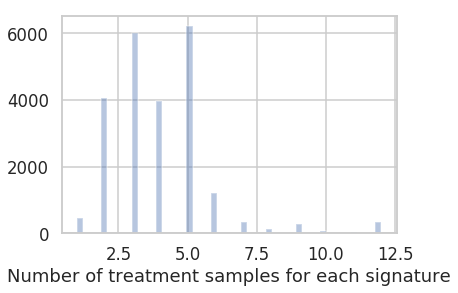

In [30]:
ax = sns.distplot(sig_info_df['n_distil_ids'], kde=False)
ax.set_xlabel('Number of treatment samples for each signature');

In [31]:
# remove signatures with only one distil_id
sig_info_df = sig_info_df.query('n_distil_ids > 1')
sig_info_df.shape

(22664, 14)

In [32]:
sig_info_df['pert_id'].value_counts().head(10)

BRD-K81418486    173
BRD-A75409952    122
BRD-A19037878    121
BRD-A19500257    121
BRD-K27305650     49
BRD-A90490067     42
BRD-K02130563     37
BRD-A13084692     33
BRD-K88742110     32
BRD-K64024097     32
Name: pert_id, dtype: int64

In [33]:
sig_info_df['pert_iname'].value_counts().head(10)

vorinostat        173
wortmannin        126
trichostatin-a    125
geldanamycin      121
LY-294002          49
fulvestrant        49
panobinostat       37
sirolimus          35
troglitazone       33
BRD-K64024097      32
Name: pert_iname, dtype: int64

In [34]:
# Only look at the signatures from the top drugs
top10_pert_ids = sig_info_df['pert_id'].value_counts().head(10).index
sig_info_df_sub = sig_info_df.loc[sig_info_df['pert_id'].isin(
    top10_pert_ids
)]
sig_info_df_sub.shape

(762, 14)

## 2.2. Examination of batch effects in the Level 5 data (signatures)

1. Qualitatively and quantitatively inspect the batch effects by tSNE and quality metrics:
    - Adjusted Random Index (ARI): [0, 1]
        + 0 -> random labeling
        + 1 -> identical clusters
    - Adjusted Mutual Information (AMI): [0, 1]
        + 0 -> random labeling
        + 1 -> identical clusters
    
1. Inspect batch effects by examining the distribution of connectivity scores

In [35]:
import benchmarks

In [36]:
gctx5 = h5py.File('%s/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx' % DATA_DIR, 'r')

In [37]:
mat5 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                               cids=sig_info_df_sub.index.values.astype(np.str))
mat5.shape

(762, 978)

In [38]:
# Load level5 data from CD pipelines with batch effect corrections
gctx5_cd_center = h5py.File('%s/results/CD_center_level5_PC3_n978x22664.gctx' % DATA_MODULE3_DIR, 'r')
mat5_cd_center = gctx_utils.slice_matrix(gctx5_cd_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index.values.astype(np.str), transpose=True)

gctx5_avg_center = h5py.File('%s/results/Avg_center_level5_PC3_n978x22664.gctx' % DATA_MODULE3_DIR, 'r')
mat5_avg_center = gctx_utils.slice_matrix(gctx5_avg_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index.values.astype(np.str), transpose=True)
print(mat5_cd_center.shape, mat5_avg_center.shape)

(762, 978) (762, 978)


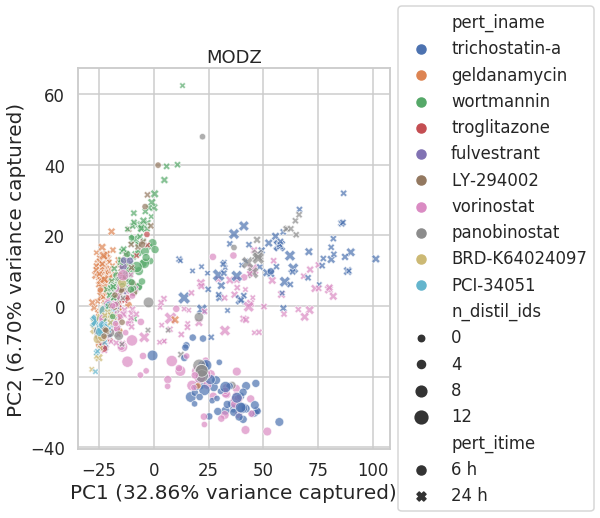

In [39]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('MODZ');
# We can see nice separation of signatures by the drugs, but this can be further improved.

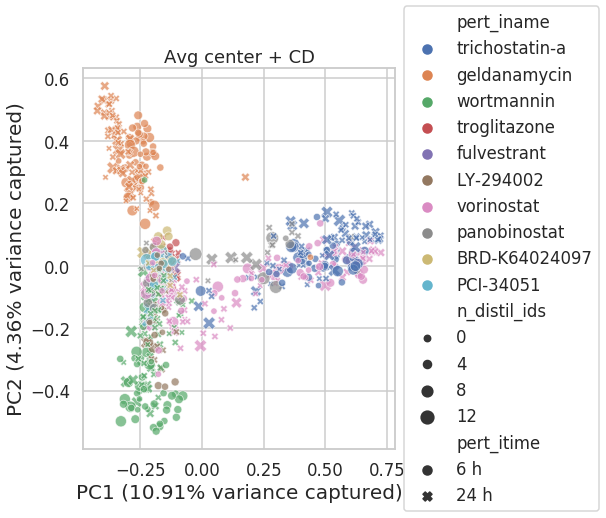

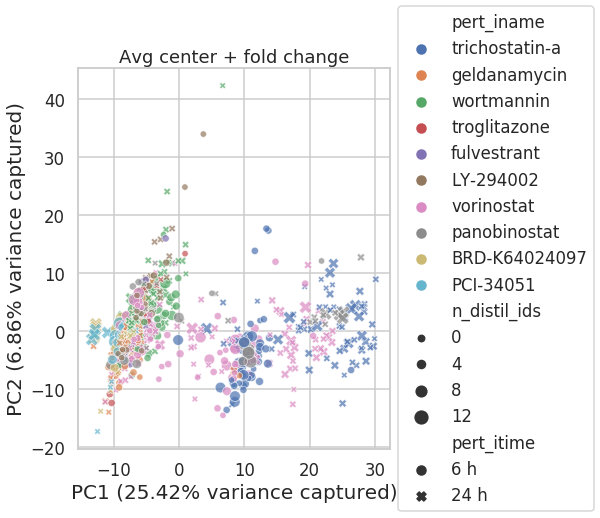

In [40]:
fig = plots.PCA_plot(mat5_cd_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('Avg center + CD');

fig = plots.PCA_plot(mat5_avg_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('Avg center + fold change');

In [41]:
sig_info_df_sub['pert_plate'].nunique()

47

In [42]:
mat5_tsne, sig_info_df_sub = benchmarks.perform_tsne_and_clustering(mat5, sig_info_df_sub, 
                                                                    sig_name='MODZ')

ARI batch: 0.0477
ARI drug: 0.2584
AMI batch: 0.1068
AMI drug: 0.3974


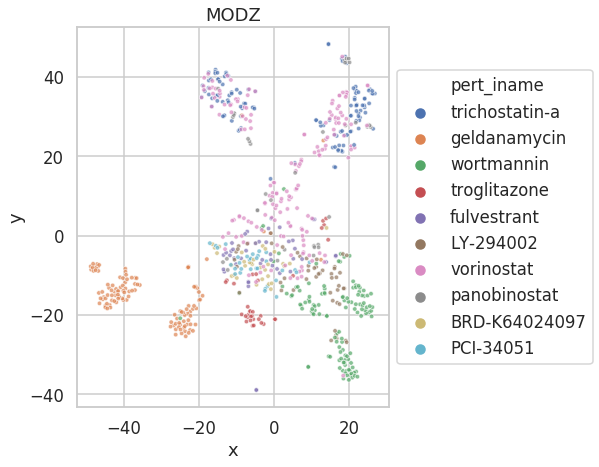

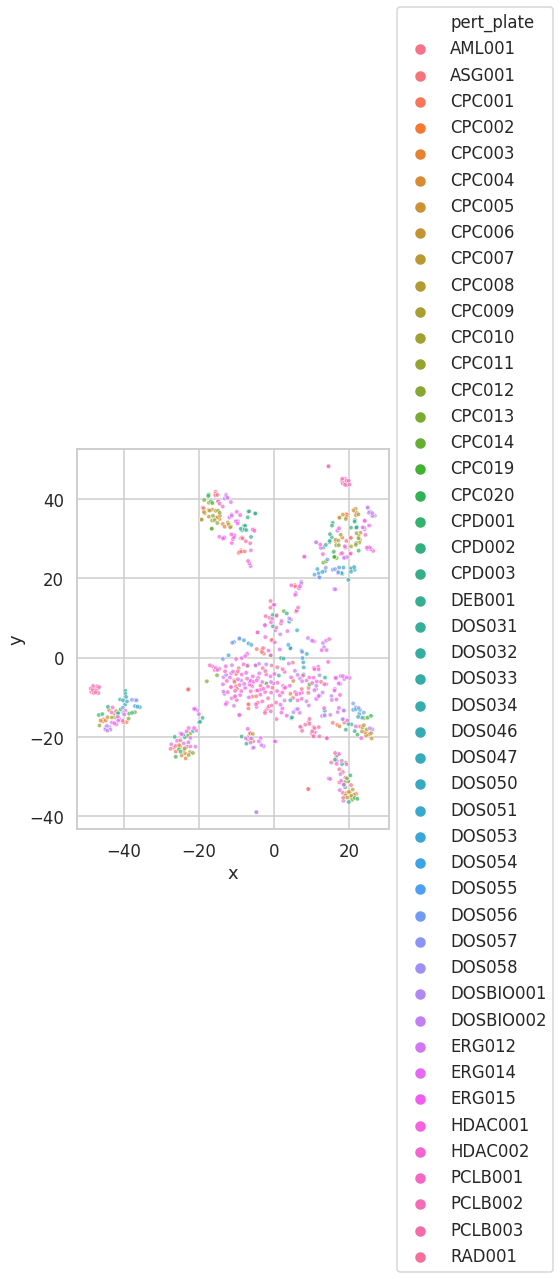

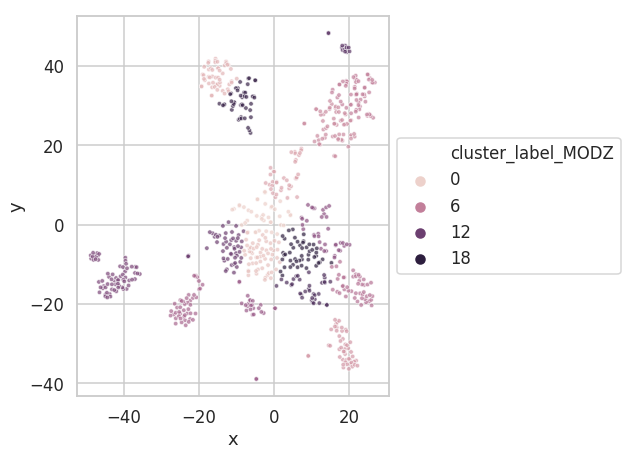

In [43]:
fig = plots.scatter_plot(mat5_tsne, sig_info_df_sub, hue='pert_iname')
fig.get_axes()[0].set_title('MODZ');

fig = plots.scatter_plot(mat5_tsne, sig_info_df_sub, hue='pert_plate')

fig = plots.scatter_plot(mat5_tsne, sig_info_df_sub, hue='cluster_label_MODZ')

print('ARI batch: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_MODZ']))
print('ARI drug: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_MODZ']))

print('AMI batch: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_MODZ']))
print('AMI drug: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_MODZ']))

In [44]:
mat5_cd_center_tsne, sig_info_df_sub = benchmarks.perform_tsne_and_clustering(mat5_cd_center, sig_info_df_sub, 
                                                                  sig_name='CD_center')

ARI batch: 0.0243
ARI drug: 0.2815
AMI batch: 0.0706
AMI drug: 0.4098


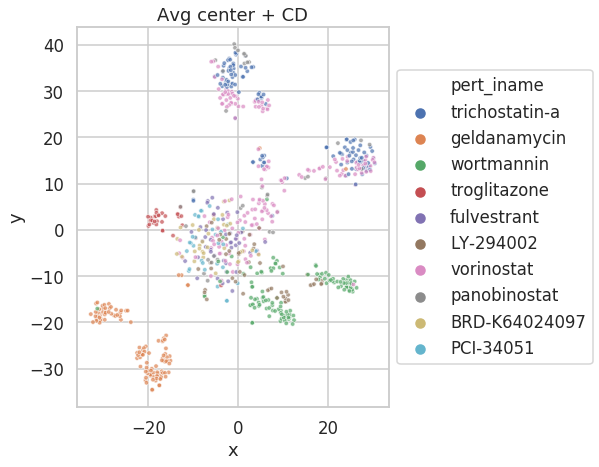

In [45]:
fig = plots.scatter_plot(mat5_cd_center_tsne, sig_info_df_sub, hue='pert_iname')
fig.get_axes()[0].set_title('Avg center + CD');
# fig = plots.scatter_plot(mat5_cd_center_tsne, sig_info_df_sub, hue='pert_plate')

print('ARI batch: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_CD_center']))
print('ARI drug: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_CD_center']))

print('AMI batch: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_CD_center']))
print('AMI drug: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_CD_center']))

In [46]:
mat5_avg_center_tsne, sig_info_df_sub = benchmarks.perform_tsne_and_clustering(mat5_avg_center, sig_info_df_sub, 
                                                                    sig_name='avg_center')

ARI batch: 0.0354
ARI drug: 0.2485
AMI batch: 0.0746
AMI drug: 0.3881


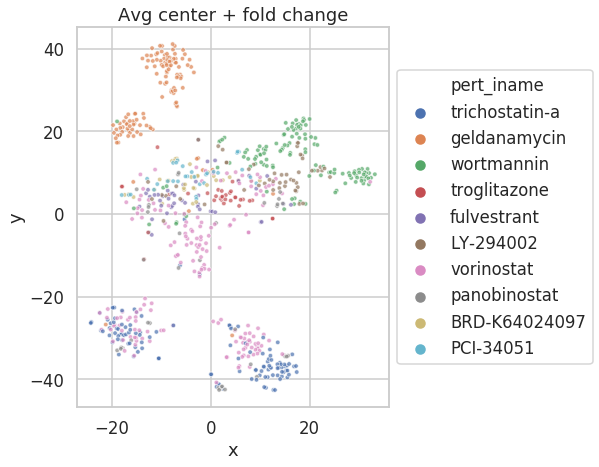

In [47]:
fig = plots.scatter_plot(mat5_avg_center_tsne, sig_info_df_sub, hue='pert_iname')
fig.get_axes()[0].set_title('Avg center + fold change');
# fig = plots.scatter_plot(mat5_avg_center_tsne, sig_info_df_sub, hue='pert_plate')

print('ARI batch: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_avg_center']))
print('ARI drug: %.4f'% metrics.adjusted_rand_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_avg_center']))

print('AMI batch: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_plate'], sig_info_df_sub['cluster_label_avg_center']))
print('AMI drug: %.4f'% metrics.adjusted_mutual_info_score(sig_info_df_sub['pert_id'], sig_info_df_sub['cluster_label_avg_center']))

### 2.2.2. Inspect batch effects by examining the distribution of connectivity scores

In [48]:
conn_scores = benchmarks.compute_pairwise_connectivity_scores(mat5, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 31052 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 289941 out of 289941 | elapsed:   16.6s finished


2231 38771 10500 238439


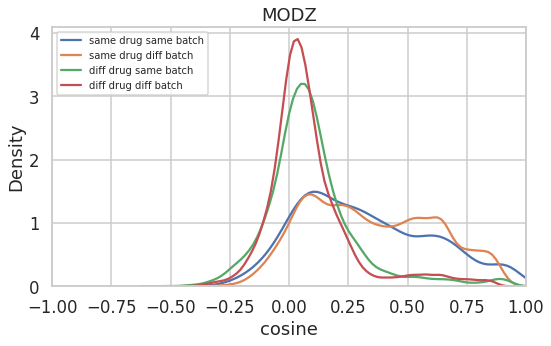

In [49]:
fig = benchmarks.density_plot_scores(conn_scores, sig_info_df_sub)
fig.get_axes()[0].set_title('MODZ');

In [50]:
conn_scores_cd_center = benchmarks.compute_pairwise_connectivity_scores(mat5_cd_center, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 31720 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 289941 out of 289941 | elapsed:   16.7s finished


2231 38771 10500 238439


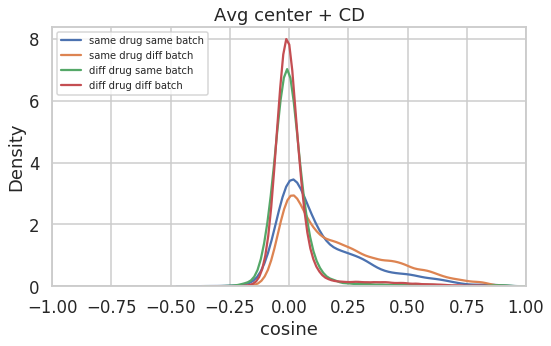

In [51]:
fig = benchmarks.density_plot_scores(conn_scores_cd_center, sig_info_df_sub)
fig.get_axes()[0].set_title('Avg center + CD');

In [52]:
conn_scores_avg_center = benchmarks.compute_pairwise_connectivity_scores(mat5_avg_center, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 33968 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 289941 out of 289941 | elapsed:   15.5s finished


2231 38771 10500 238439


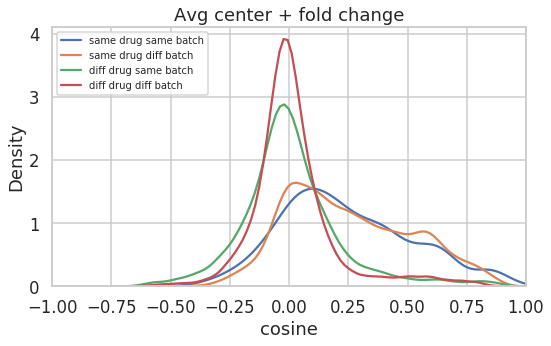

In [53]:
fig = benchmarks.density_plot_scores(conn_scores_avg_center, sig_info_df_sub)
fig.get_axes()[0].set_title('Avg center + fold change');

# 3. Interactive visualization of the signatures

1. Interactive scatter plots
1. Graph-based dimensionality reduction methods: Overview of the method used to create the [L1000FWD visualizations](http://amp.pharm.mssm.edu/L1000FWD/) ([Wang et al. (2018) _Bioinformatics_](https://doi.org/10.1093/bioinformatics/bty060))   

In [54]:
# Load data downloaded from RepurposingHub
drug_moa_df = pd.read_csv('%s/parsed_Repurposing_Hub.csv' % DATA_MODULE3_DIR).set_index('pert_id')
drug_moa_df = drug_moa_df.fillna('Unknown')
drug_moa_df['MOA'] = drug_moa_df['MOA'].map(lambda x:x.split(', ')[0])
print(drug_moa_df.shape)
drug_moa_df.head()

(6172, 5)


Name                                         MOA  \
pert_id                                                               
BRD-K38019854  A-317491              purinergic receptor antagonist   
BRD-A40302156   A-33903                                     Unknown   
BRD-K06182768     A-366  histone lysine methyltransferase inhibitor   
BRD-K78177893  A-674563                               AKT inhibitor   
BRD-K03301001       A-7                       calmodulin antagonist   

                           Target Indication        Phase  
pert_id                                                    
BRD-K38019854               P2RX3    Unknown  Preclinical  
BRD-A40302156             Unknown    Unknown      Phase 2  
BRD-K06182768        EHMT1, EHMT2    Unknown  Preclinical  
BRD-K78177893  AKT1, PKIA, PRKACA    Unknown  Preclinical  
BRD-K03301001             Unknown    Unknown  Preclinical

In [55]:
# Keep signatures from drugs with known MOA/Targets
sig_info_df_known_drugs = sig_info_df.loc[sig_info_df.pert_id.isin(drug_moa_df.index)]
sig_info_df_known_drugs.shape

(6285, 14)

In [56]:
sig_info_df_known_drugs.head()

pert_id  pert_iname pert_type  \
sig_id                                                                     
AML001_PC3_6H:BRD-A45664787:0.37037  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:1.11111  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:10       BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:3.33333  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-K27316855:0.37037  BRD-K27316855  calcitriol    trt_cp   

                                    cell_id pert_dose pert_dose_unit  \
sig_id                                                                 
AML001_PC3_6H:BRD-A45664787:0.37037     PC3   0.37037             µM   
AML001_PC3_6H:BRD-A45664787:1.11111     PC3   1.11111             µM   
AML001_PC3_6H:BRD-A45664787:10          PC3        10             µM   
AML001_PC3_6H:BRD-A45664787:3.33333     PC3   3.33333             µM   
AML001_PC3_6H:BRD-K27316855:0.37037     PC3   0.37037             µM   

                                    pert_idose  pert_time pert_time_unit  \
sig_id                                                                     
AML001_PC3_6H:BRD-A45664787:0.37037     500 nM          6              h   
AML001_PC3_6H:BRD-A45664787:1.11111       1 µM          6              h   
AML001_PC3_6H:BRD-A45664787:10           10 µM          6              h   
AML001_PC3_6H:BRD-A45664787:3.33333       3 µM          6              h   
AML001_PC3_6H:BRD-K27316855:0.37037     500 nM          6              h   

                                    pert_itime  \
sig_id                                           
AML001_PC3_6H:BRD-A45664787:0.37037        6 h   
AML001_PC3_6H:BRD-A45664787:1.11111        6 h   
AML001_PC3_6H:BRD-A45664787:10             6 h   
AML001_PC3_6H:BRD-A45664787:3.33333        6 h   
AML001_PC3_6H:BRD-K27316855:0.37037        6 h   

                                                                             distil_id  \
sig_id                                                                                   
AML001_PC3_6H:BRD-A45664787:0.37037  AML001_PC3_6H_X1_F1B10:J24|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:1.11111  AML001_PC3_6H_X1_F1B10:J23|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:10       AML001_PC3_6H_X1_F1B10:I23|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:3.33333  AML001_PC3_6H_X1_F1B10:I24|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-K27316855:0.37037  AML001_PC3_6H_X1_F1B10:J22|AML001_PC3_6H_X2_F1...   

                                             batch pert_plate  n_distil_ids  
sig_id                                                                       
AML001_PC3_6H:BRD-A45664787:0.37037  AML001_PC3_6H     AML001             6  
AML001_PC3_6H:BRD-A45664787:1.11111  AML001_PC3_6H     AML001             6  
AML001_PC3_6H:BRD-A45664787:10       AML001_PC3_6H     AML001             6  
AML001_PC3_6H:BRD-A45664787:3.33333  AML001_PC3_6H     AML001             6  
AML001_PC3_6H:BRD-K27316855:0.37037  AML001_PC3_6H     AML001             3

In [57]:
# Retrieve all signatures
sig_mat = gctx_utils.slice_matrix(gctx5_cd_center, rids=LM_GENE_IDS, 
                                  cids=sig_info_df_known_drugs.index.values.astype(np.str), 
                                  transpose=True)
sig_mat.shape

(6285, 978)

In [58]:
pca = decomposition.PCA(n_components=20)
sig_mat_pca = pca.fit_transform(sig_mat)

tsne = manifold.TSNE(verbose=10)
sig_mat_tsne = tsne.fit_transform(sig_mat_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6285 samples in 0.005s...
[t-SNE] Computed neighbors for 6285 samples in 1.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6285
[t-SNE] Computed conditional probabilities for sample 2000 / 6285
[t-SNE] Computed conditional probabilities for sample 3000 / 6285
[t-SNE] Computed conditional probabilities for sample 4000 / 6285
[t-SNE] Computed conditional probabilities for sample 5000 / 6285
[t-SNE] Computed conditional probabilities for sample 6000 / 6285
[t-SNE] Computed conditional probabilities for sample 6285 / 6285
[t-SNE] Mean sigma: 0.095078
[t-SNE] Computed conditional probabilities in 0.302s
[t-SNE] Iteration 50: error = 89.0583115, gradient norm = 0.0090099 (50 iterations in 3.235s)
[t-SNE] Iteration 100: error = 88.7143784, gradient norm = 0.0001922 (50 iterations in 3.068s)
[t-SNE] Iteration 150: error = 88.7127762, gradient norm = 0.0000468 (50 iterations in 2.915s)
[t-SNE] Iteration 200: error = 

In [59]:
sig_info_df_known_drugs = sig_info_df_known_drugs.merge(drug_moa_df, 
                                                        left_on='pert_id', 
                                                        right_index=True, 
                                                        how='left')

In [60]:
frequent_MOAs = set(sig_info_df_known_drugs['MOA'].value_counts()[:19].index)
sig_info_df_known_drugs['MOA_frequent'] = [moa if moa in frequent_MOAs else 'other' \
                                           for moa in sig_info_df_known_drugs['MOA']]

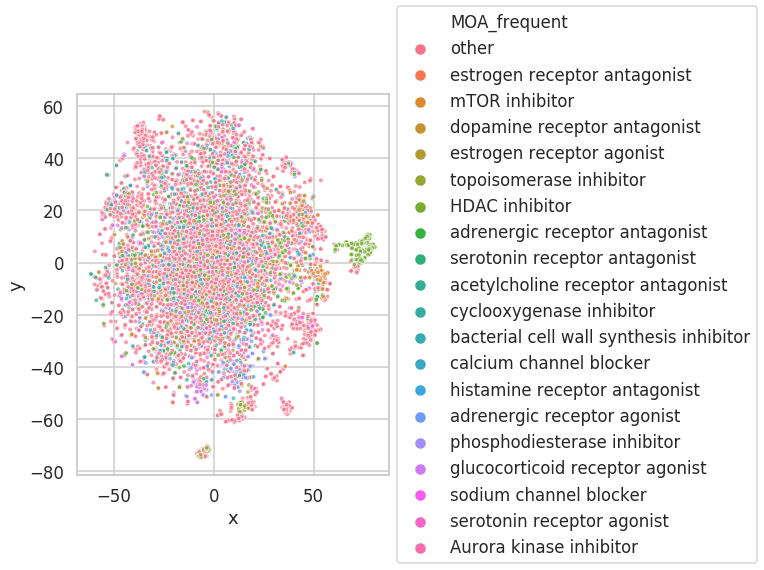

In [61]:
fig = plots.scatter_plot(sig_mat_tsne, sig_info_df_known_drugs, hue='MOA_frequent')

In [62]:
import umap

In [63]:
sig_mat_umap =  umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(sig_mat)
sig_mat_umap.shape

(6285, 2)

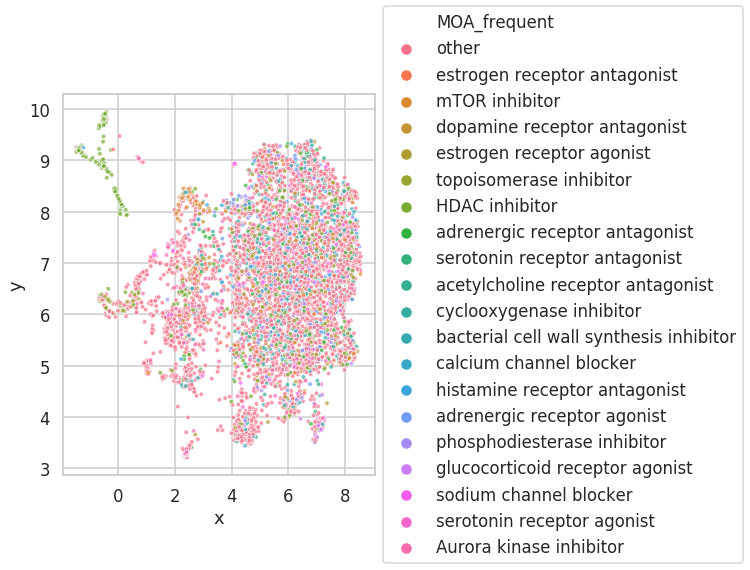

In [64]:
fig = plots.scatter_plot(sig_mat_umap, sig_info_df_known_drugs, hue='MOA_frequent')

In [65]:
plots.plotly_webgl_scatter(sig_mat_tsne, sig_info_df_known_drugs, 
                     hue='MOA_frequent', 
                     label_cols=['pert_iname', 'MOA'])

## 3.2. Graph-based dimensionality reduction for L1000 signatures 

**Workflow:**

1. Starts with $\mathbf{X}$ ($n \times m$ signatures by genes)
1. Compute pairwise distance/similarity matrix -> $\mathbf{A}$ ($n \times n$)
1. Construct a graph $G$ to represent the local and global geometric/topological structures of the data, the graph can be a k-Nearest Neighbor graph
1. Project $G$ into lower-dimensional space using graph layout algorithms, e.g., [Fruchterman-Reingold force-directed layout](https://onlinelibrary.wiley.com/doi/abs/10.1002/spe.4380211102), edge-repulsive strong clustering and others.


In [66]:
import graph_utils
import plots

In [67]:
sig_mat.shape

(6285, 978)

In [68]:
# Sample 1000 signatures for faster computation of the graph
sample_idx = np.random.choice(sig_mat.shape[0], 1000, replace=False)

sig_info_df_known_drugs_sample = sig_info_df_known_drugs.iloc[sample_idx]
# G = graph_utils.create_knn_graph(sig_mat[sample_idx], k=5, metric='euclidean', n_jobs=6)
G = graph_utils.create_knn_graph(sig_mat[sample_idx], k=3, metric='cosine', n_jobs=6)
G.number_of_nodes(), G.number_of_edges()

(1000, 2257)

In [69]:
# Convert to igraph.Graph
G = graph_utils.nx_graph_to_igraph(G)

In [70]:
# Perform Fruchterman-Reingold force-dirceted layout algorithm for the graph
layt = G.layout_fruchterman_reingold_3d(maxdelta=1500, maxiter=1000) 

In [71]:
frequent_MOAs = set(sig_info_df_known_drugs_sample['MOA'].value_counts()[:19].index)
sig_info_df_known_drugs_sample['MOA_frequent'] = [moa if moa in frequent_MOAs else 'other' \
                                           for moa in sig_info_df_known_drugs_sample['MOA']]

In [72]:
plots.plotly_network(G, layt, sig_info_df_known_drugs_sample,
                          hue='MOA_frequent',
                          label_cols=['pert_iname', 'MOA'])